In [2]:
# Import necessary libraries
from simphony.libraries import siepic
from simphony.die import Die
from simphony.simulation import Simulation, Laser, Detector
import matplotlib.pyplot as plt
from phidl import quickplot, set_quickplot_options

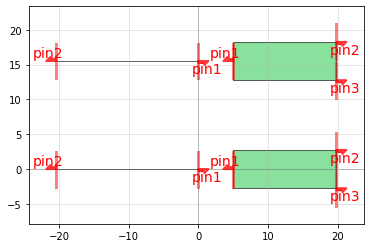

In [3]:
# Instantiate components
gc_input = siepic.GratingCoupler(name="gcinput")
y_splitter = siepic.YBranch(name="ysplit")
wg_long = siepic.Waveguide(length=150e-6, name="wglong")
wg_short = siepic.Waveguide(length=50e-6, name="wgshort")
y_recombiner = siepic.YBranch(name="yrecombiner")
gc_output = siepic.GratingCoupler(name="gcoutput")

# Instantiate Die object
die = Die(name="die1")

# Throw in the components into the Die
die.add_components([gc_input, y_splitter, wg_long, gc_output, y_recombiner, wg_short])

# Distribute the devices in the die in a grid
die.distribute_devices(direction='grid', shape=(3,2), spacing=(5,10))

# Visualize the grid arrangement
die.visualize(label_aliases=True)

In [4]:
# We connect the components like we would usually. Simphony will take care of the routing and
# device connections for us.

# Do not show ports when plotting the layout
set_quickplot_options(False, False, label_aliases=True)

# next we connect the components to each other
y_splitter["pin1"].connect(gc_input["pin1"])

y_recombiner["pin1"].connect(gc_output["pin1"])

y_splitter["pin2"].connect(wg_long)
y_recombiner["pin3"].connect(wg_long)

y_splitter["pin3"].connect(wg_short)
y_recombiner["pin2"].connect(wg_short)

KeyError: 'pin3'

In [1]:
# Visualize after connecting
set_quickplot_options(show_ports=False, show_subports=False, label_aliases=True)
die.visualize(show_ports=False) # Visualize after connecting

NameError: name 'set_quickplot_options' is not defined

In [ ]:
# Run the layout aware monte carlo computation
with Simulation() as sim:
    l = Laser(power=1)
    l.freqsweep(187370000000000.0, 199862000000000.0)
    l.connect(gc_input['pin2'])
    d = Detector()
    d.connect(gc_output['pin2'])

    results = sim.layout_aware_simulation()

In [ ]:
# Plot the results
f = l.freqs
for run in results:
    p = []
    for sample in run:
        for data_list in sample:
            for data in data_list:
                p.append(data)
    plt.plot(f, p)

run = results[0]
p = []
for sample in run:
    for data_list in sample:
        for data in data_list:
            p.append(data)
plt.plot(f, p, 'k')
plt.title('MZI Layout Aware Monte Carlo')
plt.show()

In [ ]:
# Plot cumulative distribution function
import numpy as np

# Get maximum P
max = []
for run in results:
    p = []
    for sample in run:
        for data_list in sample:
            for data in data_list:
                p.append(data)
    max.append(np.max(p))
#sort data
x = np.sort(max)

#calculate CDF values
y = 1. * np.arange(len(max)) / (len(max) - 1)

#plot CDF
plt.plot(x, y)
plt.xlabel('x')

In [ ]:
from simphony.die import Die
die2 = Die()
die2.add_components([gc_input, y_splitter, wg_long, gc_output, y_recombiner, wg_short])
import seaborn as sns
sns.set_context('notebook')
sns.set_theme()

In [ ]:
die2.distribute_devices(direction='y')
set_quickplot_options(label_aliases=True, font_size=5)
die2.visualize(font_size=5)

In [ ]:
# We connect the components like we would usually. Simphony will take care of the routing and
# device connections for us.

# Do not show ports when plotting the layout
set_quickplot_options(False, False, label_aliases=True)

# next we connect the components to each other
y_splitter["pin1"].connect(gc_input["pin1"])

y_recombiner["pin1"].connect(gc_output["pin1"])

y_splitter["pin2"].connect(wg_long)
y_recombiner["pin3"].connect(wg_long)

y_splitter["pin3"].connect(wg_short)
y_recombiner["pin2"].connect(wg_short)

In [ ]:
die2.visualize()

In [ ]:
from simphony import Model
Model.pin_count = 1

In [ ]:
mappings = {
    "simphony.libraries.siepic": {
        "ebeam_bdc_te1550": {"name": "BidirectionalCoupler", "parameters": {
            "lay_x": "device.x",
            "lay_y": "device.y",
        }}
    }
}

In [ ]:
from simphony.libraries import siepic
pdk = siepic
mapping = mappings["simphony.libraries.siepic"]["ebeam_bdc_te1550"]
mapping

In [ ]:
component = {
    "params": {
        "lay_x": 0,
        "lay_y": 0,
    }
}

parameters = {mapping["parameters"][k]: v for k, v in component["params"].items() if k in mapping["parameters"]}

In [ ]:
bdc = getattr(pdk, mapping["name"])(**parameters)

In [ ]:
quickplot(bdc.device)

In [ ]:
from simphony.formatters import CircuitSiEPICFormatter
from simphony.layout import Circuit
circuit = Circuit.from_file("C:\\Users\\12269\\Downloads\\top_main.spi", \
    formatter=CircuitSiEPICFormatter())

In [ ]:
from simphony.die import Die
die = Die()
die.add_components(circuit._get_components())

In [ ]:
for i, c in enumerate(circuit._get_components()):
    for k, pin in enumerate(c.pins):
        print(i, k, pin._connection)

In [ ]:
circuit._get_components()[10].pins[1].disconnect()

In [ ]:
die.visualize()

In [ ]:
# Run the layout aware monte carlo computation
with Simulation() as sim:
    l = Laser(power=1)
    l.freqsweep(187370000000000.0, 199862000000000.0)
    l.connect(circuit._get_components()[1])
    d = Detector()
    d.connect(circuit._get_components()[5])

    results = sim.layout_aware_simulation()

In [ ]:
f = l.freqs
for run in results:
    p = []
    for sample in run:
        for data_list in sample:
            for data in data_list:
                p.append(data)
    plt.plot(f, p)

run = results[0]
p = []
for sample in run:
    for data_list in sample:
        for data in data_list:
            p.append(data)
plt.plot(f, p, 'k')
plt.title('MZI Layout Aware Monte Carlo')
plt.show()

In [ ]:
# Disconnect test
y_splitter.disconnect()

In [ ]:
die.visualize()

In [ ]:
for component in y_recombiner.circuit._get_components():
    component.disconnect()
die.visualize()